<a href="https://colab.research.google.com/github/nurikahraman/FoodTracker/blob/main/OpenCv_Perspective_Transformation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **OpenCv Perspective Transformation**
**KAYNAK:**
https://medium.com/analytics-vidhya/opencv-perspective-transformation-9edffefb2143

**NOTLAR**:
Şu an için en sondaki not defterini kullanmacaksın
[Üzerinde Çalışacağın Not Defteri Linki](https://colab.research.google.com/drive/1SoNK5J1lHq4S861cImgf2i9amrg_8UOR#scrollTo=5O-0bkiQqBM0&line=4&uniqifier=1)

Perspektif Dönüşümü, görüntüyü düzgün bir şekilde hizalamak istiyorsanız çok kullanışlı olan bir özelliktir. Perspektif Dönüşümü uygulandıktan sonra görüntüyü düz bir şekilde dönüştürür.
Bunun klasik bir örneği: Tablodaki sayfayı yalnızca sayfayı seçecek şekilde dönüştürmek ve görüntünün üstten görünümü olarak görünecek şekilde dönüştürmek

OpenCv Perspektif Dönüşümü işlevine girmeden önce, formülün, algoritmanın nasıl göründüğüne ve perde arkasında neler olduğuna biraz bakacağız.

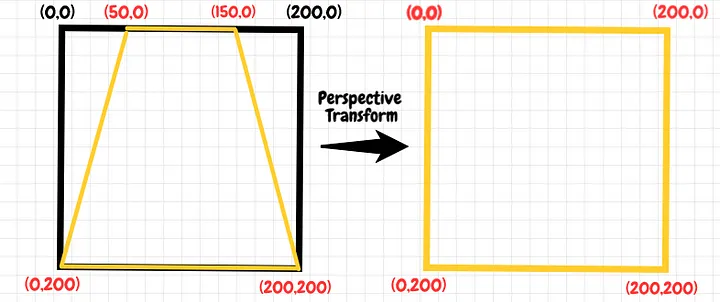

*Soldaki yukarıdaki resimde*

*Koordinatlar :[[50,0],[150,0],[0,200],[200,200]]*

*Dönüştürülmesi gereken yeni Koordinatlar :[[0,0],[200,0],[0,200],[200,200]]*

**Aşağıda örnek hesaplama verilmiştir**

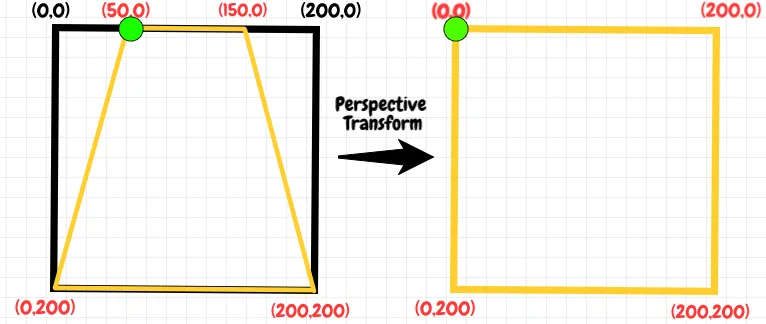

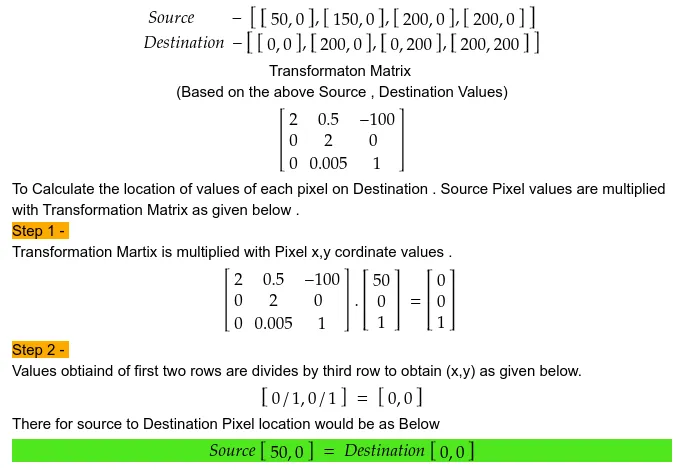

**İkinci hesaplama örneği**

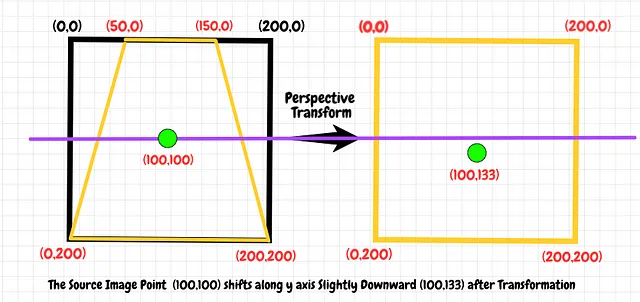

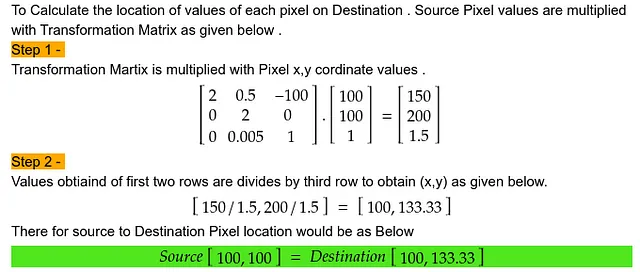

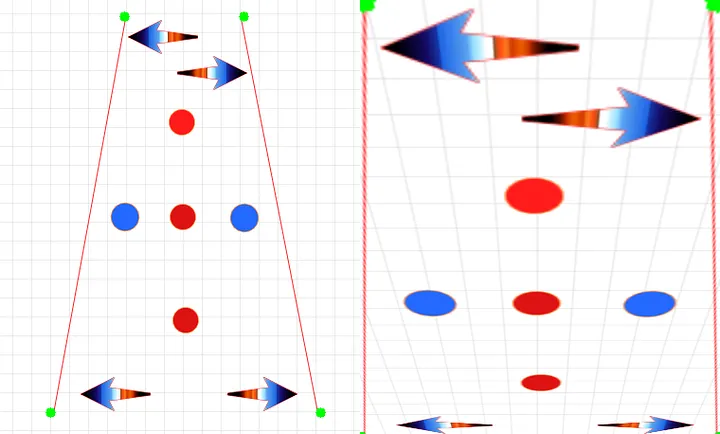

Resimden de görebileceğiniz gibi, tüm yatay Paralel çizgiler dönüşümden sonra Paralel tutulur. Dikey Paralel çizgiler Dönüşümden sonra birbirine Paralel değildir.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**OpenCv'de Perspektif Dönüşümünün Uygulanması**

In [ ]:
#!pip install opencv-python
#!pip install numpy
#!pip install imutils

In [10]:
import cv2
from operator import itemgetter
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import argparse
import imutils
import numpy as np
from google.colab.patches import cv2_imshow

In [61]:
def calculate_corners(contour_points):
    corners = np.zeros((4, 2), dtype="float32")
    sum_points = contour_points.sum(axis=1)
    corners[0] = contour_points[np.argmin(sum_points)]
    corners[2] = contour_points[np.argmax(sum_points)]
    diff_points = np.diff(contour_points, axis=1)
    corners[1] = contour_points[np.argmin(diff_points)]
    corners[3] = contour_points[np.argmax(diff_points)]
    return corners

In [62]:
def transform_perspective(input_image, contour_points):
    corners = calculate_corners(contour_points)
    (top_left, top_right, bottom_right, bottom_left) = corners

    width_top = np.linalg.norm(bottom_right - bottom_left)
    width_bottom = np.linalg.norm(top_right - top_left)
    max_width = max(int(width_top), int(width_bottom))

    height_left = np.linalg.norm(top_right - bottom_right)
    height_right = np.linalg.norm(top_left - bottom_left)
    max_height = max(int(height_left), int(height_right))

    destination = np.array([
        [0, 0],
        [max_width - 1, 0],
        [max_width - 1, max_height - 1],
        [0, max_height - 1]
    ], dtype="float32")

    matrix = cv2.getPerspectiveTransform(corners, destination)
    output_image = cv2.warpPerspective(input_image, matrix, (max_width, max_height))

    return output_image

STEP 1: Edge Detection


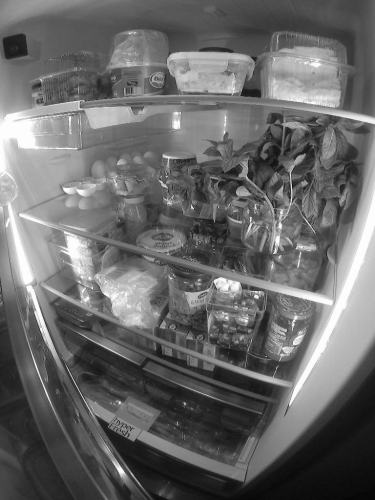

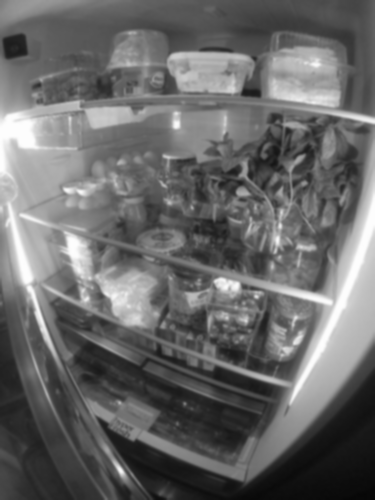

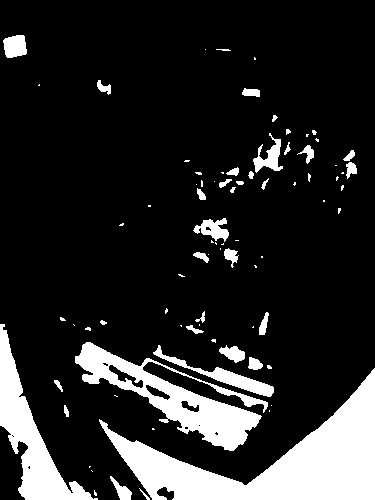

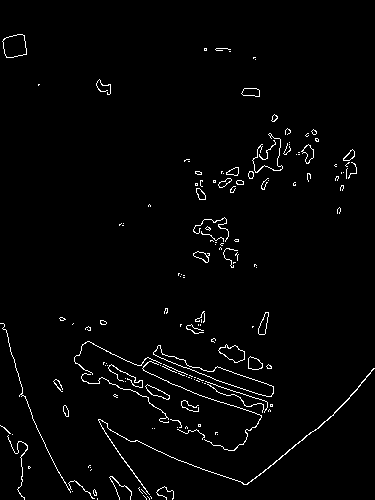

contour_perimeter :47.55634891986847

approximated_contour :[[[248 358]]

 [[248 368]]

 [[258 369]]

 [[262 367]]

 [[262 363]]

 [[258 359]]

 [[250 356]]]
detected_screen :None
No valid screen contour found.


In [32]:
def process_image():
    image_path = '/content/drive/MyDrive/Colab Notebooks/Photo Tools/test_image/captured_photo_1024.jpg'
    if not os.path.exists(image_path):
        raise ValueError(f"Image file not found at path: {image_path}")
    original_image = cv2.imread(image_path)
    image_ratio = original_image.shape[0] / 500.0
    resized_image = imutils.resize(original_image, height=500)

    gray_image = cv2.cvtColor(resized_image, cv2.COLOR_BGR2GRAY)
    blurred_image = cv2.GaussianBlur(gray_image, (5, 5), 0)
    (T, threshInv50) = cv2.threshold(blurred_image, 50, 255, cv2.THRESH_BINARY_INV)
    edge_detected = cv2.Canny(threshInv50, 500, 10)

    # STEP 1: Edge Detection
    print("STEP 1: Edge Detection")
    cv2_imshow(gray_image)
    cv2_imshow(blurred_image)
    cv2_imshow(threshInv50)
    cv2_imshow(edge_detected)

    contours = cv2.findContours(edge_detected.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = imutils.grab_contours(contours)
    sorted_contours = sorted(contours, key=cv2.contourArea, reverse=True)[:5]

    detected_screen = None
    for contour in sorted_contours:
        contour_perimeter = cv2.arcLength(contour, True)
        approximated_contour = cv2.approxPolyDP(contour, 0.02 * contour_perimeter, True)

        if len(approximated_contour) == 4:
            detected_screen = approximated_contour
            break

    print(f"contour_perimeter :{contour_perimeter}\n")
    print(f"approximated_contour :{approximated_contour}")
    print(f"detected_screen :{detected_screen}")

    if detected_screen is not None:
        # STEP 2: Finding Boundary
        print("STEP 2: Finding Boundary")
        cv2.drawContours(resized_image, [detected_screen], -1, (0, 255, 0), 2)
        cv2_imshow(resized_image)

        transformed_image = transform_perspective(original_image, detected_screen.reshape(4, 2) * image_ratio)
        grayscale_transformed = cv2.cvtColor(transformed_image, cv2.COLOR_BGR2GRAY)

        # STEP 3: Apply Perspective Transform
        print("STEP 3: Apply Perspective Transform")
        cv2_imshow(transformed_image)
        cv2.imwrite('scanned_document.jpg', transformed_image)
        cv2.waitKey(0)
    else:
        print("No valid screen contour found.")

    cv2.destroyAllWindows()
if __name__ == "__main__":
    process_image()

STEP 1: Edge Detection


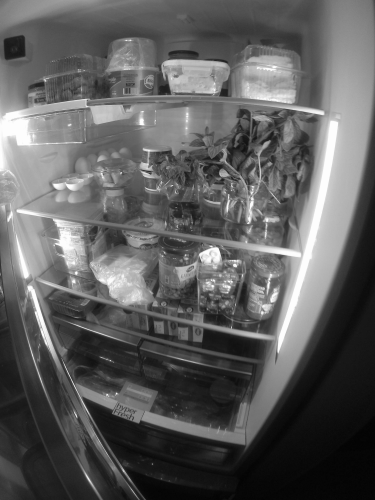

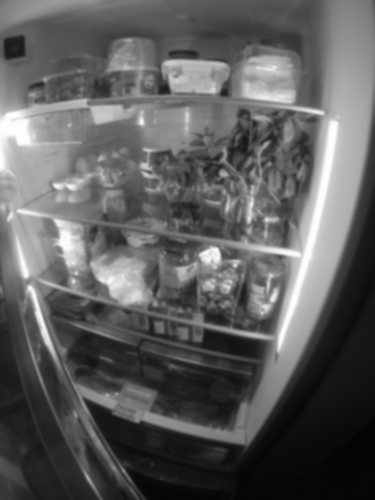

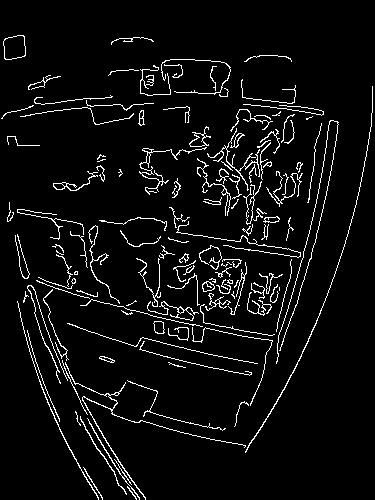

STEP 2: Finding Boundary


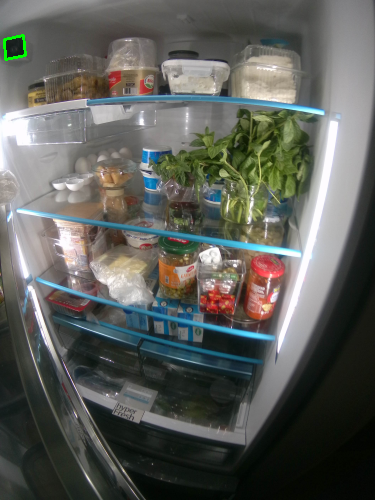

STEP 3: Apply Perspective Transform


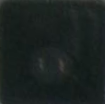

In [66]:
if __name__ == "__main__":
    process_image()



 Source Image Size: [(2592, 1944)]
 Result Image Size: [(2592, 1944)]


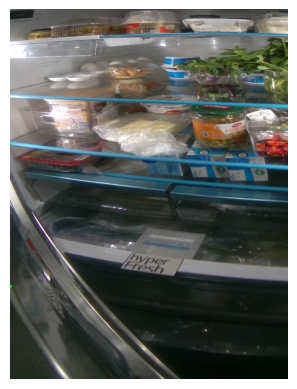

In [50]:
image_path = '/content/drive/MyDrive/Colab Notebooks/Photo Tools/test_image/captured_photo_5mp_2.jpg'
if not os.path.exists(image_path):
    raise ValueError(f"Image file not found at path: {image_path}")

# Perspektif dönüşüm örneği
paper = cv2.imread(image_path)
if paper is None:
    raise ValueError(f"Could not read image file at path: {image_path}")
image_width, image_height = paper.shape[0:2]

# Perspektif dönüşümde kullanılacak dört kaynak nokta (pts1)
# Bu noktalar, resmin ortasına yakın dört köşe olarak belirlenmiştir
pts1 = np.float32([
    [16,176],  # Sol üst köşe
    [1936,176],  # Sağ üst köşe
    [304,2176],  # Sol alt köşe
    [1280,2320]   # Sağ alt köşe
])

# Perspektif dönüşümde kullanılacak dört hedef nokta (pts2)
# Hedef resimde bu noktalar resmin köşelerine denk gelir
pts2 = np.float32([
    [0, 0],             # Sol üst köşe
    [image_width, 0],   # Sağ üst köşe
    [0, image_height],  # Sol alt köşe
    [image_width, image_height]  # Sağ alt köşe
])
# Görüntü üzerinde noktaları işaretleme
for val in pts1:
    cv2.circle(paper, (int(val[0]), int(val[1])), 5, (0, 255, 0), -1)

# Perspektif dönüşüm matrisini hesaplama
M = cv2.getPerspectiveTransform(pts1, pts2)

# Perspektif dönüşümü uygulama
dst = cv2.warpPerspective(paper, M, (image_height, image_width))

# Dönüşüm sonucu görüntüyü görselleştirme
print(f"\n\n Source Image Size: [{paper.shape[0:2]}]\n Result Image Size: [{dst.shape[0:2]}]")
plt.imshow(cv2.cvtColor(dst, cv2.COLOR_BGR2RGB))

plt.axis('off')  # Eksenleri kapatma
plt.show()

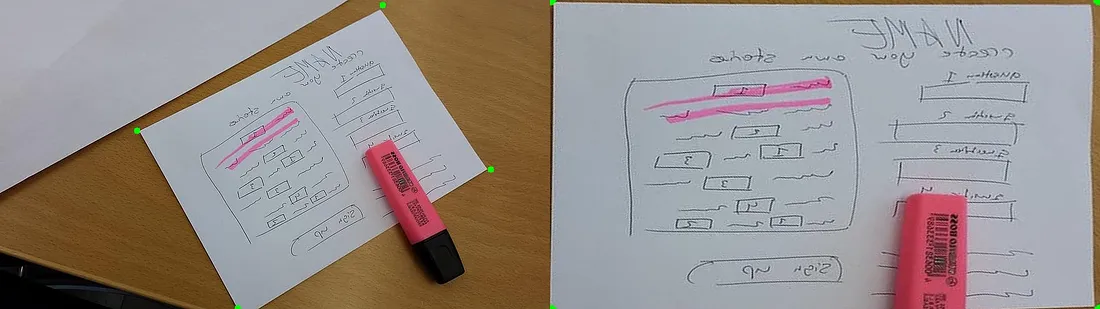

Yukarıdaki resimden de görebileceğiniz gibi, Perspektif Dönüştürme işlevi görüntüdeki Yatay çizgileri nasıl korur ve kağıt için üstten görünümü elde etmeyi başarır. Aşağıda verilen bazı örnek resimler

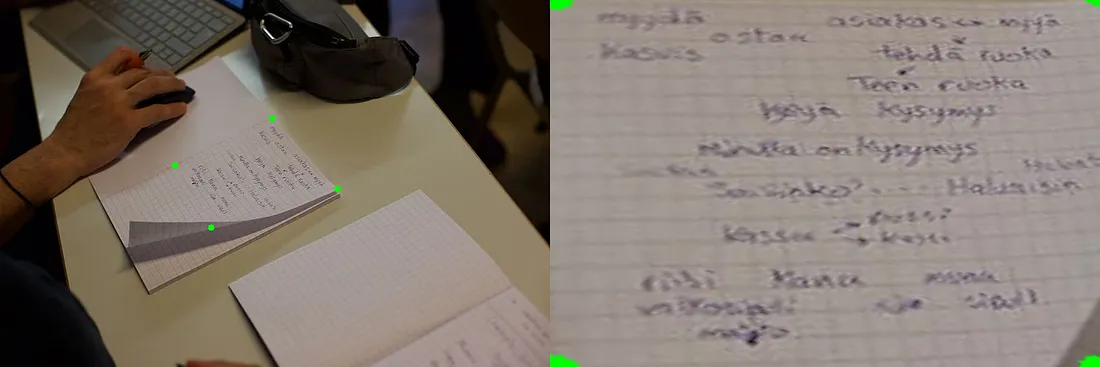

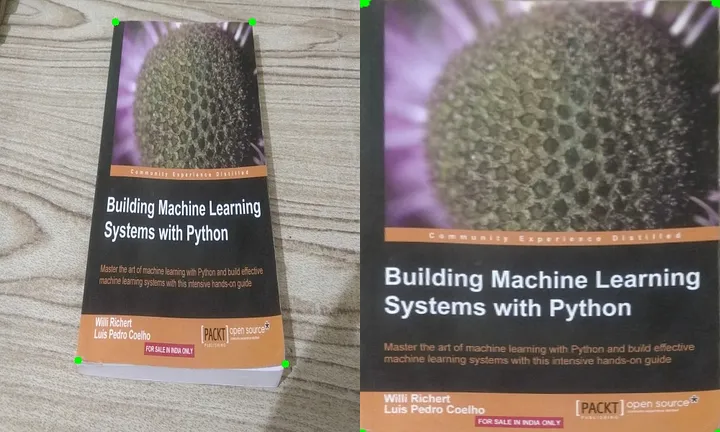

**Referans**

https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_geometric_transformations/py_geometric_transformations.html
http://jlouthan.github.io/perspective-transform/examples/test-ui/index.html

**HARRIS Yöntemi ile köşe algılama**

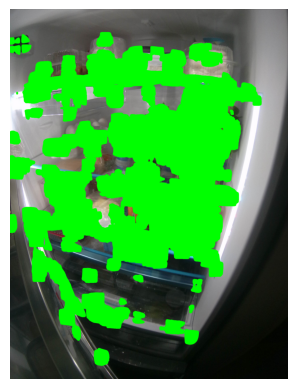

In [107]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Görüntü yükleme
image_path = '/content/drive/MyDrive/Colab Notebooks/Photo Tools/test_image/captured_photo_5mp_2.jpg'
if not os.path.exists(image_path):
    raise ValueError(f"Image file not found at path: {image_path}")

paper = cv2.imread(image_path)
if paper is None:
    raise ValueError(f"Could not read image file at path: {image_path}")

# Harris köşe algılama parametreleri
block_size = 2
aperture_size = 3
k = 0.01

# Harris köşe algılama
gray = cv2.cvtColor(paper, cv2.COLOR_BGR2GRAY)
dst = cv2.cornerHarris(gray, block_size, aperture_size, k)

# Köşelerin işaretlenmesi ve belirlenmesi
dst = cv2.dilate(dst, None)
threshold = 0.01 * dst.max()
paper[dst > threshold] = [0, 0, 255]  # Köşeleri kırmızıyla işaretleyelim

# Köşe noktalarını belirleme
corner_points = np.argwhere(dst > threshold)[:, ::-1]  # Köşe noktalarının x ve y koordinatlarını al

# Köşe noktalarını görselleştirme
for point in corner_points:
    cv2.circle(paper, tuple(point), 5, (0, 255, 0), -1)

# Görüntü üzerinde belirlenen köşe noktalarını görselleştirme
plt.imshow(cv2.cvtColor(paper, cv2.COLOR_BGR2RGB))
plt.axis('off')  # Eksenleri kapatma
plt.show()


**Shi-Tomasi Yöntemi ile köşe algılama**

<ipython-input-8-b3299a2d7bf7>:27: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  corners = np.int0(corners)


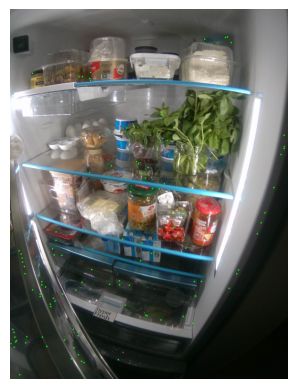

In [8]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Görüntü yükleme
image_path = '/content/drive/MyDrive/Colab Notebooks/Photo Tools/test_image/captured_photo_5mp_2.jpg'
if not os.path.exists(image_path):
    raise ValueError(f"Image file not found at path: {image_path}")

paper = cv2.imread(image_path)
if paper is None:
    raise ValueError(f"Could not read image file at path: {image_path}")

# Shi-Tomasi köşe algılama parametreleri
max_corners = 100
quality_level = 0.01
min_distance = 10
block_size = 3

# Shi-Tomasi köşe algılama
gray = cv2.cvtColor(paper, cv2.COLOR_BGR2GRAY)
corners = cv2.goodFeaturesToTrack(gray, max_corners, quality_level, min_distance, blockSize=block_size)

# Köşe noktalarını belirleme ve işaretlenmesi
corners = np.int0(corners)
for corner in corners:
    x, y = corner.ravel()
    cv2.circle(paper, (x, y), 5, (0, 255, 0), -1)

# Görüntü üzerinde belirlenen köşe noktalarını görselleştirme
plt.imshow(cv2.cvtColor(paper, cv2.COLOR_BGR2RGB))
plt.axis('off')  # Eksenleri kapatma
plt.show()


**Shi-Tomasi Yöntemi ile köşe algılama**

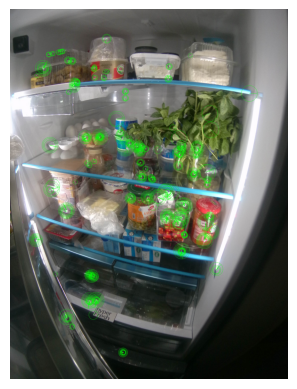

In [113]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Görüntü yükleme
image_path = '/content/drive/MyDrive/Colab Notebooks/Photo Tools/test_image/captured_photo_5mp_2.jpg'
if not os.path.exists(image_path):
    raise ValueError(f"Image file not found at path: {image_path}")

paper = cv2.imread(image_path)
if paper is None:
    raise ValueError(f"Could not read image file at path: {image_path}")

# ORB özellik tanıma
orb = cv2.ORB_create()
keypoints, descriptors = orb.detectAndCompute(paper, None)

# Köşe noktalarını işaretleme
paper_with_keypoints = cv2.drawKeypoints(paper, keypoints, None, (0,255,0), 4)

# Görüntü üzerinde belirlenen köşe noktalarını görselleştirme
plt.imshow(cv2.cvtColor(paper_with_keypoints, cv2.COLOR_BGR2RGB))
plt.axis('off')  # Eksenleri kapatma
plt.show()

**SIFT Yöntemi ile köşe algılama**

(< cv2.KeyPoint 0x78faa1e3de00>, < cv2.KeyPoint 0x78faa1e3d830>, < cv2.KeyPoint 0x78faa1e3e430>, < cv2.KeyPoint 0x78faa1e3d860>, < cv2.KeyPoint 0x78faa1e77780>, < cv2.KeyPoint 0x78faa825e580>, < cv2.KeyPoint 0x78faa825f3c0>, < cv2.KeyPoint 0x78faa825eaf0>, < cv2.KeyPoint 0x78faa825d0b0>, < cv2.KeyPoint 0x78faa825c9c0>, < cv2.KeyPoint 0x78faa825daa0>, < cv2.KeyPoint 0x78faa825ea00>, < cv2.KeyPoint 0x78faa825eb80>, < cv2.KeyPoint 0x78faa825e4f0>, < cv2.KeyPoint 0x78faa825eb50>, < cv2.KeyPoint 0x78faa825f1e0>, < cv2.KeyPoint 0x78faa825fa20>, < cv2.KeyPoint 0x78faa825e670>, < cv2.KeyPoint 0x78faa825d1a0>, < cv2.KeyPoint 0x78faa825edc0>, < cv2.KeyPoint 0x78faa825e6d0>, < cv2.KeyPoint 0x78faa825f720>, < cv2.KeyPoint 0x78faa825d590>, < cv2.KeyPoint 0x78faa825fd50>, < cv2.KeyPoint 0x78faa825d3e0>, < cv2.KeyPoint 0x78faa8375b90>, < cv2.KeyPoint 0x78faa8374960>, < cv2.KeyPoint 0x78faa8377de0>, < cv2.KeyPoint 0x78faa8374780>, < cv2.KeyPoint 0x78faa8377d80>, < cv2.KeyPoint 0x78faa83749f0>, < cv2.K

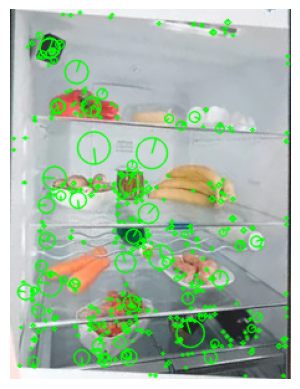

In [121]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Görüntü yükleme
image_path = '/content/drive/MyDrive/Colab Notebooks/Photo Tools/test_image/captured_photo_5mp_2.jpg'
if not os.path.exists(image_path):
    raise ValueError(f"Image file not found at path: {image_path}")

paper = cv2.imread(image_path)
if paper is None:
    raise ValueError(f"Could not read image file at path: {image_path}")

# SIFT özellik tanıma
sift = cv2.SIFT_create()
keypoints, descriptors = sift.detectAndCompute(paper, None)
# Köşe noktalarını işaretleme
paper_with_keypoints = cv2.drawKeypoints(paper, keypoints, None, (0,255,0), 4)

# Görüntü üzerinde belirlenen köşe noktalarını görselleştirme
plt.imshow(cv2.cvtColor(paper_with_keypoints, cv2.COLOR_BGR2RGB))
print(keypoints)
print(descriptors)
plt.axis('off')  # Eksenleri kapatma
plt.show()


**ORB Yöntemi ile köşe algılama**

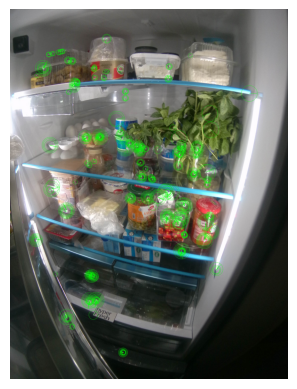

In [115]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Görüntü yükleme
image_path = '/content/drive/MyDrive/Colab Notebooks/Photo Tools/test_image/captured_photo_5mp_2.jpg'
if not os.path.exists(image_path):
    raise ValueError(f"Image file not found at path: {image_path}")

paper = cv2.imread(image_path)
if paper is None:
    raise ValueError(f"Could not read image file at path: {image_path}")

# ORB özellik tanıma
orb = cv2.ORB_create()
keypoints, descriptors = orb.detectAndCompute(paper, None)

# Köşe noktalarını işaretleme
paper_with_keypoints = cv2.drawKeypoints(paper, keypoints, None, (0,255,0), 4)

# Görüntü üzerinde belirlenen köşe noktalarını görselleştirme
plt.imshow(cv2.cvtColor(paper_with_keypoints, cv2.COLOR_BGR2RGB))
plt.axis('off')  # Eksenleri kapatma
plt.show()


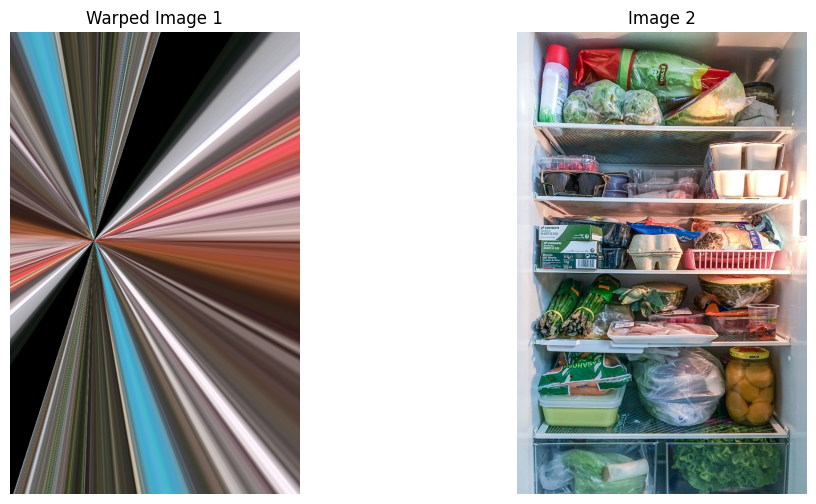

In [50]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# İlk ve ikinci görüntüyü yükleme
image1_path = '/content/drive/MyDrive/Colab Notebooks/Photo Tools/test_image/captured_photo_1024.jpg'
image2_path = '/content/drive/MyDrive/Colab Notebooks/Photo Tools/test_image/buzdolabi_ici.jpg'

image1 = cv2.imread(image1_path)
image2 = cv2.imread(image2_path)

# ORB algortimasini oluşturma
orb = cv2.ORB_create()

# İlk ve ikinci görüntüler için özellikleri ve açıklamaları (descriptors) bulma
keypoints1, descriptors1 = orb.detectAndCompute(image1, None)
keypoints2, descriptors2 = orb.detectAndCompute(image2, None)

# Brute-Force Matcher ile eşleştirme yapma
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
matches = bf.match(descriptors1, descriptors2)

# En iyi eşleşmeleri sıralama
matches = sorted(matches, key=lambda x: x.distance)

# İlk 10 eşleşmeyi kullanarak homografi (perspektif dönüşüm matrisi) hesaplama
src_pts = np.float32([keypoints1[m.queryIdx].pt for m in matches[:130]]).reshape(-1, 1, 2)
dst_pts = np.float32([keypoints2[m.trainIdx].pt for m in matches[:130]]).reshape(-1, 1, 2)
M, _ = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

# İlk görüntüyü ikinci görüntüye dönüştürme
image1_warped = cv2.warpPerspective(image1, M, (image2.shape[1], image2.shape[0]))

# Görüntüleri yan yana gösterme
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(cv2.cvtColor(image1_warped, cv2.COLOR_BGR2RGB))
axes[0].set_title('Warped Image 1')
axes[0].axis('off')
axes[1].imshow(cv2.cvtColor(image2, cv2.COLOR_BGR2RGB))
axes[1].set_title('Image 2')
axes[1].axis('off')
plt.show()

In [ ]:
# import the necessary packages
import argparse
import cv2
from google.colab.patches import cv2_imshow
import numpy as np
import matplotlib.pyplot as plt


image_path = '/content/drive/MyDrive/Colab Notebooks/Photo Tools/test_image/captured_photo_800.jpg'

image = cv2.imread(image_path)
#cv2_imshow(image)
# convert the image to grayscale and blur it slightly
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (7, 7), 0)



# apply basic thresholding -- the first parameter is the image
# we want to threshold, the second value is is our threshold
# check; if a pixel value is greater than our threshold (in this
# case, 200), we set it to be *black, otherwise it is *white*
(T, threshInv30) = cv2.threshold(blurred, 30, 255, cv2.THRESH_BINARY_INV)
#cv2_imshow(threshInv)

(T, threshInv40) = cv2.threshold(blurred, 40, 255, cv2.THRESH_BINARY_INV)
(T, threshInv50) = cv2.threshold(blurred, 50, 255, cv2.THRESH_BINARY_INV)

(T, threshInv60) = cv2.threshold(blurred, 60, 255, cv2.THRESH_BINARY_INV)
(T, threshInv70) = cv2.threshold(blurred, 70, 255, cv2.THRESH_BINARY_INV)

(T, threshInv80) = cv2.threshold(blurred, 80, 255, cv2.THRESH_BINARY_INV)
(T, threshInv90) = cv2.threshold(blurred, 90, 255, cv2.THRESH_BINARY_INV)



# Görüntüleri yan yana gösterme
fig, axes = plt.subplots(1, 8, figsize=(600, 300))
axes[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
axes[0].set_title('Warped Image 1')
axes[0].axis('off')
axes[1].imshow(cv2.cvtColor(threshInv30, cv2.COLOR_BGR2RGB))
axes[1].set_title('Image 30')
axes[1].axis('off')
axes[2].imshow(cv2.cvtColor(threshInv40, cv2.COLOR_BGR2RGB))
axes[2].set_title('Image 40')
axes[2].axis('off')
axes[3].imshow(cv2.cvtColor(threshInv50, cv2.COLOR_BGR2RGB))
axes[3].set_title('Image 50')
axes[3].axis('off')
axes[4].imshow(cv2.cvtColor(threshInv60, cv2.COLOR_BGR2RGB))
axes[4].set_title('Image 60')
axes[4].axis('off')
axes[5].imshow(cv2.cvtColor(threshInv70, cv2.COLOR_BGR2RGB))
axes[5].set_title('Image 70')
axes[5].axis('off')
axes[6].imshow(cv2.cvtColor(threshInv80, cv2.COLOR_BGR2RGB))
axes[6].set_title('Image 80')
axes[6].axis('off')
axes[7].imshow(cv2.cvtColor(threshInv90, cv2.COLOR_BGR2RGB))
axes[7].set_title('Image 90')
axes[7].axis('off')

plt.show()


# using normal thresholding (rather than inverse thresholding)
#(T, thresh) = cv2.threshold(blurred, 200, 255, cv2.THRESH_BINARY)
#cv2_imshow(thresh)


# visualize only the masked regions in the image
#masked = cv2.bitwise_and(image, image, mask=threshInv)
#cv2_imshow(masked)
#cv2.waitKey(0)




Nihayi deneyeceğin kod parçası bu olacak. Buzdolabının tam dikdörtgen iç ve kapak fotoğrafları gerekecek gerçek sonucu görmek için.

In [80]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# İlk ve ikinci görüntüyü yükleme
image1_path = '/content/drive/MyDrive/Colab Notebooks/Photo Tools/test_image/captured_photo_5mp_1.jpg'
image2_path = '/content/drive/MyDrive/Colab Notebooks/Photo Tools/test_image/captured_photo_5mp_2.jpg'

img1 = cv2.imread(image1_path, cv2.IMREAD_GRAYSCALE)  # referenceImage
img2 = cv2.imread(image2_path, cv2.IMREAD_GRAYSCALE)  # sensedImage

#  Resize the image by a factor of 8 on each side. If your images are
# very high-resolution, you can try to resize even more, but if they are
# already small you should set this to something less agressive.
resize_factor = 1.0/8.0

img1_rs = cv2.resize(img1, None, fx=resize_factor, fy=resize_factor)
img2_rs = cv2.resize(img2, None, fx=resize_factor, fy=resize_factor)

# Initiate SIFT detector
sift_detector = cv2.SIFT_create(nfeatures=1000)

# Find the keypoints and descriptors with SIFT on the lower resolution images
kp1, des1 = sift_detector.detectAndCompute(img1_rs, None)
kp2, des2 = sift_detector.detectAndCompute(img2_rs, None)

# BFMatcher with default params
bf = cv2.BFMatcher()
matches = bf.knnMatch(des1, des2, k=2)

# Filter out poor matches
good_matches = []
for m,n in matches:
    if m.distance < 0.65*n.distance:
        good_matches.append(m)

# Check if there are at least 4 good matches
if len(good_matches) < 4:
    raise ValueError("Not enough good matches to calculate homography.")

matches = good_matches
points1 = np.zeros((len(matches), 2), dtype=np.float32)
points2 = np.zeros((len(matches), 2), dtype=np.float32)

for i, match in enumerate(matches):
    points1[i, :] = kp1[match.queryIdx].pt
    points2[i, :] = kp2[match.trainIdx].pt

# Find homography
H, mask = cv2.findHomography(points1, points2, cv2.RANSAC)

# Get low-res and high-res sizes
low_height, low_width = img1_rs.shape
height, width = img1.shape
low_size = np.float32([[0, 0], [0, low_height], [low_width, low_height], [low_width, 0]])
high_size = np.float32([[0, 0], [0, height], [width, height], [width, 0]])

# Compute scaling transformations
scale_up = cv2.getPerspectiveTransform(low_size, high_size)
scale_down = cv2.getPerspectiveTransform(high_size, low_size)

#  Combine the transformations. Remember that the order of the transformation
# is reversed when doing matrix multiplication
# so this is actualy scale_down -> H -> scale_up
h_and_scale_up = np.matmul(scale_up, H)
scale_down_h_scale_up = np.matmul(h_and_scale_up, scale_down)

# Warp image 1 to align with image 2
img1Reg = cv2.warpPerspective(
            img1,
            scale_down_h_scale_up,
            (img2.shape[1], img2.shape[0])
          )

cv2.imwrite('/content/drive/MyDrive/Colab Notebooks/Photo Tools/OpenCv Perspective Transformation/aligned_img1.jpg', img1Reg)


True